In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import math
import pyflagser

In [2]:
import statistics
import sys
import pickle
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score

In [3]:
G=nx.read_gml("8500busEx.gml")
N=list(G.nodes)
E=list(G.edges)
A = nx.to_numpy_array(G)

In [4]:
import pickle
with open('PartialObservdata.pkl', 'rb') as f:
    POData = pickle.load(f)


In [5]:
N_Senario=len(POData)
print(N_Senario)

1201


In [6]:
AverageVoltage=[]
def Average(lst):
    return sum(lst) / len(lst)
Voltage=POData[0]["Bus Voltages"]
for x, y in Voltage.items():
    AverageVoltage.append(Average(list(y)))
#print(AverageVoltage)
AverageVoltage = [-1 if math.isnan(x) else x for x in AverageVoltage]
#print(AverageVoltage)
Vol_len=len(AverageVoltage)
#print(Vol_len)

In [7]:
BranchFlow=[]
Bflow=POData[100]["BranchFlow"]
for x, y in Bflow.items():
    BranchFlow.append(y)
#print(BranchFlow)

BranchFlow = [-1 if math.isnan(x) else x for x in BranchFlow]
#print(BranchFlow)
Flow_len=len(BranchFlow)
#print(Flow_len)

In [8]:
print("Filtration treshold\n*****************\n")
F_voltage=[0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.90,0.85,0.80,0.75,0.50,0.25,0,-1]
F_Flow=[300,200,175,150,125,100,75,50,30,15,10,0,-1]
p=len(F_voltage)
q=len(F_Flow)
print(p)
print(q)
print(p*q)

Filtration treshold
*****************

15
13
195


In [9]:
Class=[]
for i in range(300):
    Class.append(POData[i]["NetOutage"])
#print(Class)
i=0
l=0
m=0
while i < len(Class):
    if Class[i] == 'No':
        l=l+1
        Class[i] = 0
    if Class[i] == 'Yes':
        m=m+1
        Class[i] = 1
    i += 1
print(Class)
print(l)
print(m)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
152
148


In [ ]:
import time
start = time.time()
Vlist_b0=[]
Vlist_b1=[]
N_Senario=300
for k in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(k, 100*k//(N_Senario-1)), end='', flush=True)
    AverageVoltage=[]
    Voltage=POData[k]["Bus Voltages"]
    for x, y in Voltage.items():
        AverageVoltage.append(Average(list(y)))
    AverageVoltage = [-1 if math.isnan(x) else x for x in AverageVoltage]
    b0_points=[]
    b1_points=[]
    for p in range(len(F_voltage)):
        n_active = np.where(np.array(AverageVoltage) >= F_voltage[p])[0].tolist()
        Active_node=np.unique(n_active)
        b=A[Active_node,:][:,Active_node]
        my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
        x = my_flag["betti"]
            #print(x[0])
            #x_points.append(unique_list[k])
        b0_points.append(x[0])
        b1_points.append(x[1])
            #print(b)
            #print(x_points)
        n_active.clear()
    #print(b0_points)
    Vlist_b0.append(b0_points)
    Vlist_b1.append(b1_points)

end = time.time()
print("The time of execution of above program is :", (end-start), "s")

In [ ]:
topo_volt =np.array(Vlist_b0)
Vx1 =np.array(Vlist_b1)
n=len(Vlist_b0[0])
p=len(F_voltage)
print(p)
Feture=[]
for i in range(p):
    Feture.append("{}".format(i))
#Feture=list(range(9,17))
Vdata = pd.DataFrame(topo_volt, columns =Feture) 
Vdata.insert(loc=p,column='Class',value=Class)
Vdata.head(10)

In [ ]:
start = time.time()
Flist_b0=[]
Flist_b1=[]
N_Senario=300
for k in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(k, 100*k//(N_Senario-1)), end='', flush=True)
    BranchFlow=[]
    Bflow=POData[k]["BranchFlow"]
    for x, y in Bflow.items():
        BranchFlow.append(y)
    #print(BranchFlow)
    BranchFlow = [-1 if math.isnan(x) else x for x in BranchFlow]
    #print(BranchFlow)
    b0_points=[]
    b1_points=[]

    for q in range(len(F_Flow)):
        indices = np.where(np.array(BranchFlow) >=F_Flow[q])[0].tolist()

        for s in indices:
            n_active.append(int(N.index(E[s][0])))
            n_active.append(int(N.index(E[s][1])))
        Active_node=np.unique(n_active)
        if (len(Active_node)==0):
            b=np.array([[0,0],[0,0]])
        else:
            b=A[Active_node,:][:,Active_node]
        #b=A[Active_node,:][:,Active_node]
        my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
        x = my_flag["betti"]
            #print(x[0])
            #x_points.append(unique_list[k])
        b0_points.append(x[0])
        b1_points.append(x[1])
            #print(b)
            #print(x_points)
        n_active.clear()
    #print(b0_points)
    Flist_b0.append(b0_points)
    Flist_b1.append(b1_points)
end = time.time()
print("The time of execution of above program is :", (end-start) * 10**3, "ms")

In [ ]:
topo_branch =np.array(Flist_b0)
Fx1 =np.array(Flist_b1)
n=len(Flist_b0[0])
q=len(F_Flow)
print(q)
Feture=[]
for i in range(q):
    Feture.append("{}".format(i))
#Feture=list(range(9,17))
Fdata = pd.DataFrame(topo_branch, columns =Feture) 
Fdata.insert(loc=q,column='Class',value=Class)
Fdata.head(10)

In [ ]:
start = time.time()
list_b0=[]
list_b1=[]
N_Senario=300
for k in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(k, 100*k//(N_Senario-1)), end='', flush=True)
    AverageVoltage=[]
    Voltage=POData[k]["Bus Voltages"]
    for x, y in Voltage.items():
        AverageVoltage.append(Average(list(y)))
    AverageVoltage = [-1 if math.isnan(x) else x for x in AverageVoltage]
    #print(AverageVoltage)
    BranchFlow=[]
    Bflow=POData[k]["BranchFlow"]
    for x, y in Bflow.items():
        BranchFlow.append(y)
    #print(BranchFlow)
    BranchFlow = [-1 if math.isnan(x) else x for x in BranchFlow]
    #print(BranchFlow)
    b0_points=[]
    b1_points=[]
    for p in range(len(F_voltage)):
        for q in range(len(F_Flow)):
            n_active = np.where(np.array(AverageVoltage) > F_voltage[p])[0].tolist()
            indices = np.where(np.array(BranchFlow) > F_Flow[q])[0].tolist()
            for s in indices:
                n_active.append(int(N.index(E[s][0])))
                n_active.append(int(N.index(E[s][1])))
            Active_node=np.unique(n_active)
            if (len(Active_node)==0):
                b=np.array([[0,0],[0,0]])
            else:
                b=A[Active_node,:][:,Active_node]
            #print(Active_node)
            #b=A[Active_node,:][:,Active_node]
            my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
            x = my_flag["betti"]
            #print(x[0])
            #x_points.append(unique_list[k])
            b0_points.append(x[0])
            b1_points.append(x[1])
            #print(b)
            #print(x_points)
            n_active.clear()
    #print(b0_points)
    list_b0.append(b0_points)
    list_b1.append(b1_points)
end = time.time()
print("The time of execution of above program is :", (end-start), "s")


In [ ]:
print("Single PH using voltage information\n ******************\n")
X=topo_volt
y=np.array(Class)


# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
precision_per_flod=[]
recall_per_fold=[]
f1_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    bst = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1,booster='gbtree')

    # Train the model
    bst.fit(X[train], y[train])
    # Evaluate the model
    y_pred=bst.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    
    #skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    #plt.show()
    #print(classification_report(y[test], y_pred))
    precision=precision_score(y[test], y_pred, average=None)
    precision_per_flod.append(precision[0])
    f1score=f1_score(y[test], y_pred, average=None)
    f1_per_fold.append(f1score[0])
    recall=recall_score(y[test], y_pred, average=None)
    recall_per_fold.append(recall[0])
    #print(precision)
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    #print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

mean_pre = statistics.mean(precision_per_flod)
std_pre = statistics.stdev(precision_per_flod)
print("Mean Presision:", mean_pre)
print("Std ", std_pre)
print('****************')
mean_recall = statistics.mean(recall_per_fold)
std_recall = statistics.stdev(recall_per_fold)
print("Mean recall:", mean_recall)
print("Std ",std_recall)
print('****************')
mean_f1 = statistics.mean(f1_per_fold)
std_f1 = statistics.stdev(f1_per_fold)
print("Mean f1:", mean_f1)
print("Std ", std_f1)

In [ ]:
print("Single PH using Branch Flow information\n ******************\n")
X=topo_branch
y=np.array(Class)


# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
precision_per_flod=[]
recall_per_fold=[]
f1_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    bst = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1,booster='gbtree')

    # Train the model
    bst.fit(X[train], y[train])
    # Evaluate the model
    y_pred=bst.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    
    #skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    #plt.show()
    #print(classification_report(y[test], y_pred))
    precision=precision_score(y[test], y_pred, average=None)
    precision_per_flod.append(precision[0])
    f1score=f1_score(y[test], y_pred, average=None)
    f1_per_fold.append(f1score[0])
    recall=recall_score(y[test], y_pred, average=None)
    recall_per_fold.append(recall[0])
    #print(precision)
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    #print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1
mean_pre = statistics.mean(precision_per_flod)
std_pre = statistics.stdev(precision_per_flod)
print("Mean Presision:", mean_pre)
print("Std ", std_pre)
print('****************')
mean_recall = statistics.mean(recall_per_fold)
std_recall = statistics.stdev(recall_per_fold)
print("Mean recall:", mean_recall)
print("Std ", std_recall)
print('****************')
mean_f1 = statistics.mean(f1_per_fold)
std_f1 = statistics.stdev(f1_per_fold)
print("Mean f1:", mean_f1)
print("Std ", std_f1)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:

print("XGBoost using only voltage")

feature=[]
for i in range(p):
    feature.append("{}".format(i))


X=Vdata[feature] # Features
y=Vdata['Class']  # Labels
#y=data["Class"].astype("category")
#print(X)

bst = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1)
scores = cross_val_score(bst, X, y, cv=10)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

In [ ]:
start = time.time()
Flist_b0=[]
Flist_b1=[]
N_Senario=300
for k in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(k, 100*k//(N_Senario-1)), end='', flush=True)
    BranchFlow=[]
    Bflow=POData[k]["BranchFlow"]
    for x, y in Bflow.items():
        BranchFlow.append(y)
    #print(BranchFlow)
    BranchFlow = [-1 if math.isnan(x) else x for x in BranchFlow]
    #print(BranchFlow)
    b0_points=[]
    b1_points=[]

    for q in range(len(F_Flow)):
        indices = np.where(np.array(BranchFlow) >=F_Flow[q])[0].tolist()

        for s in indices:
            n_active.append(int(N.index(E[s][0])))
            n_active.append(int(N.index(E[s][1])))
        Active_node=np.unique(n_active)
        if (len(Active_node)==0):
            b=np.array([[0,0],[0,0]])
        else:
            b=A[Active_node,:][:,Active_node]
        #b=A[Active_node,:][:,Active_node]
        my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
        x = my_flag["betti"]
            #print(x[0])
            #x_points.append(unique_list[k])
        b0_points.append(x[0])
        b1_points.append(x[1])
            #print(b)
            #print(x_points)
        n_active.clear()
    #print(b0_points)
    Flist_b0.append(b0_points)
    Flist_b1.append(b1_points)
end = time.time()
print("The time of execution of above program is :", (end-start) * 10**3, "ms")

In [ ]:
Fx =np.array(Flist_b0)
Fx1 =np.array(Flist_b1)
n=len(Flist_b0[0])
q=len(F_Flow)
print(q)
Feture=[]
for i in range(q):
    Feture.append("{}".format(i))
#Feture=list(range(9,17))
Fdata = pd.DataFrame(Fx, columns =Feture) 
Fdata.insert(loc=q,column='Class',value=Class)
Fdata.head(10)

In [ ]:

print("XGBoost using only Branch Flow")

feature=[]
for i in range(q):
    feature.append("{}".format(i))


X=Fdata[feature] # Features
y=Fdata['Class']  # Labels
#y=data["Class"].astype("category")
#print(X)

bst = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1)
scores = cross_val_score(bst, X, y, cv=10)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

In [ ]:
start = time.time()
list_b0=[]
list_b1=[]
N_Senario=300
for k in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(k, 100*k//(N_Senario-1)), end='', flush=True)
    AverageVoltage=[]
    Voltage=POData[k]["Bus Voltages"]
    for x, y in Voltage.items():
        AverageVoltage.append(Average(list(y)))
    AverageVoltage = [-1 if math.isnan(x) else x for x in AverageVoltage]
    #print(AverageVoltage)
    BranchFlow=[]
    Bflow=POData[k]["BranchFlow"]
    for x, y in Bflow.items():
        BranchFlow.append(y)
    #print(BranchFlow)
    BranchFlow = [-1 if math.isnan(x) else x for x in BranchFlow]
    #print(BranchFlow)
    b0_points=[]
    b1_points=[]
    for p in range(len(F_voltage)):
        for q in range(len(F_Flow)):
            n_active = np.where(np.array(AverageVoltage) > F_voltage[p])[0].tolist()
            indices = np.where(np.array(BranchFlow) > F_Flow[q])[0].tolist()
            for s in indices:
                n_active.append(int(N.index(E[s][0])))
                n_active.append(int(N.index(E[s][1])))
            Active_node=np.unique(n_active)
            if (len(Active_node)==0):
                b=np.array([[0,0],[0,0]])
            else:
                b=A[Active_node,:][:,Active_node]
            #print(Active_node)
            #b=A[Active_node,:][:,Active_node]
            my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
            x = my_flag["betti"]
            #print(x[0])
            #x_points.append(unique_list[k])
            b0_points.append(x[0])
            b1_points.append(x[1])
            #print(b)
            #print(x_points)
            n_active.clear()
    #print(b0_points)
    list_b0.append(b0_points)
    list_b1.append(b1_points)
end = time.time()
print("The time of execution of above program is :", (end-start), "s")


In [ ]:
x =np.array(list_b0)
x1 =np.array(list_b1)
Feture=[]
for i in range(195):
    Feture.append("{}".format(i))
#Feture=list(range(9,17))
data = pd.DataFrame(x, columns =Feture) 
data.insert(loc=195,column='Class',value=Class)
data.head(10)

In [3]:
import pandas as pd

df_data = pd.read_csv('Feature_multi_8500.csv')
df_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,186,187,188,189,190,191,192,193,194,Class
0,0,34,34,34,34,34,34,34,34,34,...,1224,1224,1224,1224,1224,1224,1224,1224,1224,0
1,1,64,43,39,39,54,52,44,84,557,...,1154,1142,1125,1097,1034,805,554,1,1,0
2,2,64,43,39,39,54,52,44,84,557,...,1154,1142,1125,1097,1034,805,554,1,1,0
3,3,64,43,39,39,54,52,44,84,557,...,1154,1142,1125,1097,1034,805,554,1,1,0
4,4,64,43,39,39,54,52,44,84,557,...,1154,1142,1125,1097,1034,805,554,1,1,0


In [4]:
Class=df_data['Class'].to_numpy()

In [5]:
data_array=df_data.drop(['Unnamed: 0', 'Class'], axis=1)
data_array.head()

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,34,34,34,34,34,34,34,34,34,34,...,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224
1,64,43,39,39,54,52,44,84,557,822,...,1156,1154,1142,1125,1097,1034,805,554,1,1
2,64,43,39,39,54,52,44,84,557,822,...,1156,1154,1142,1125,1097,1034,805,554,1,1
3,64,43,39,39,54,52,44,84,557,822,...,1156,1154,1142,1125,1097,1034,805,554,1,1
4,64,43,39,39,54,52,44,84,557,822,...,1156,1154,1142,1125,1097,1034,805,554,1,1


In [6]:
topo_volt_branch=np.array(data_array)


Multi PH using voltage and Branch Flow information
 ******************



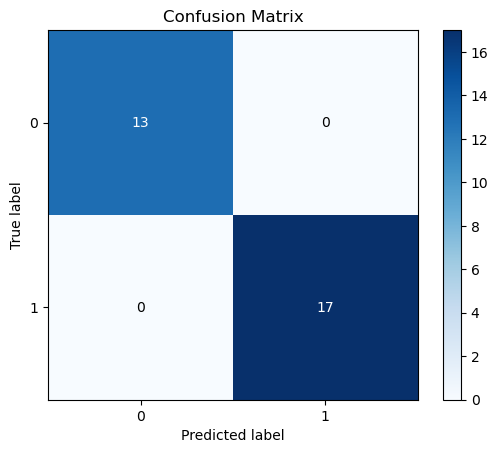

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



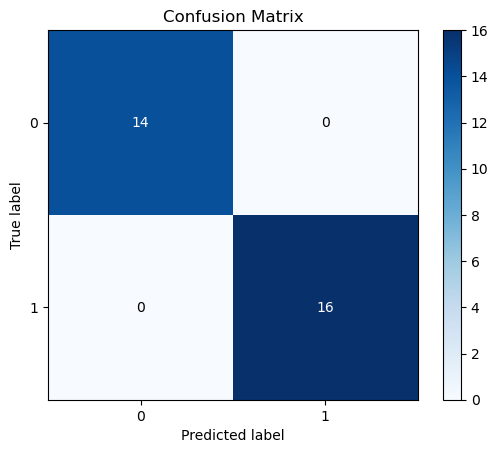

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        16

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



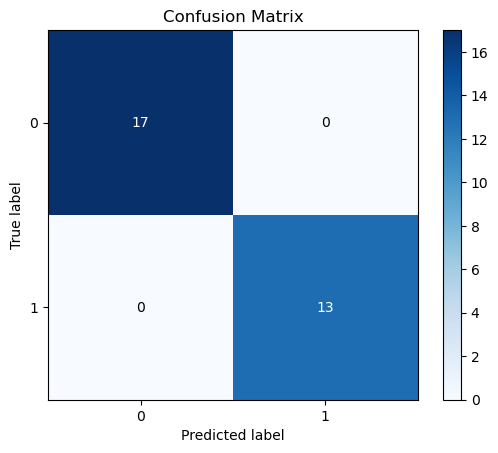

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



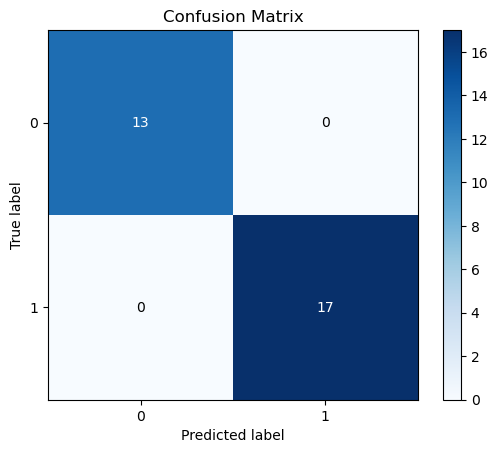

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



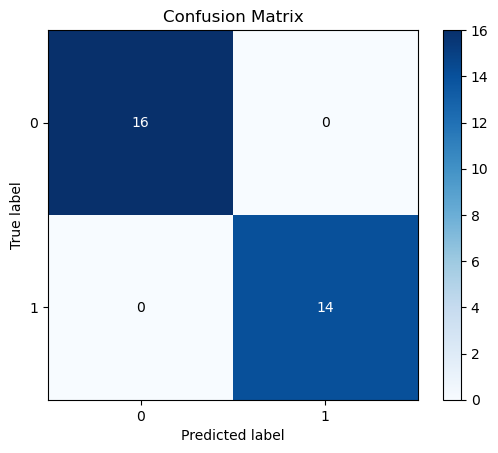

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



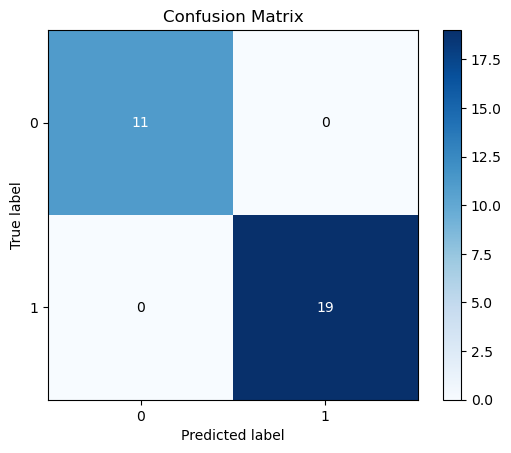

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        19

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



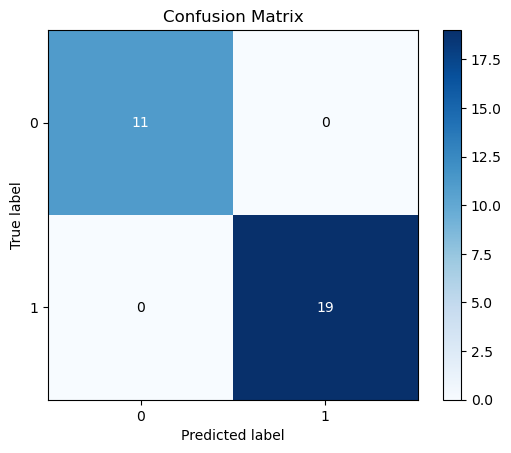

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        19

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



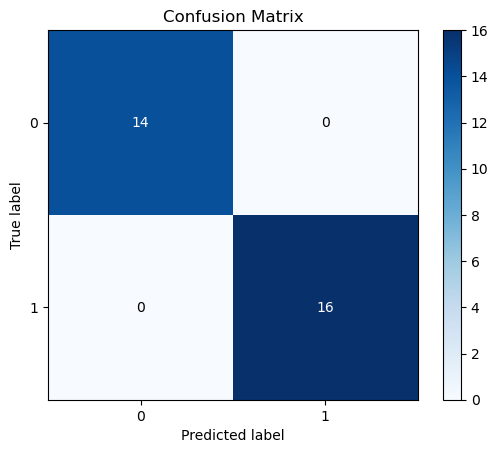

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        16

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



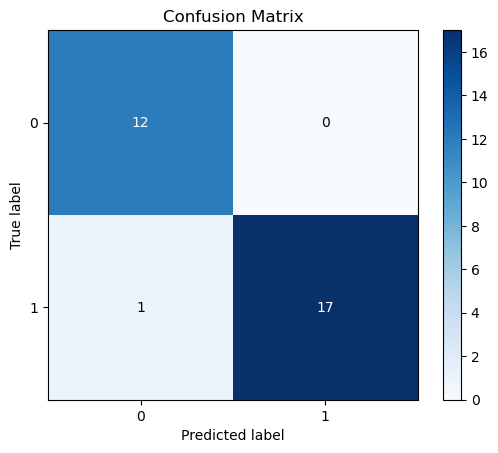

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        18

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



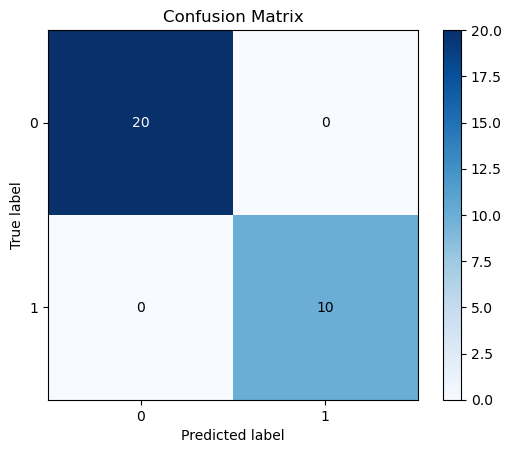

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Mean Presision: 0.9923076923076923
Std  0.02432521277052598
****************
Mean recall: 1.0
Std  0.0
****************
Mean f1: 0.996
Std  0.012649110640673493


In [9]:
print("Multi PH using voltage and Branch Flow information\n ******************\n")
X=topo_volt_branch
y=np.array(Class)


# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
precision_per_flod=[]
recall_per_fold=[]
f1_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    bst = XGBClassifier(n_estimators=200, max_depth=30, learning_rate=0.1,booster='gbtree')

    # Train the model
    bst.fit(X[train], y[train])
    # Evaluate the model
    y_pred=bst.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    
    skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    plt.show()
    print(classification_report(y[test], y_pred))
    precision=precision_score(y[test], y_pred, average=None)
    precision_per_flod.append(precision[0])
    f1score=f1_score(y[test], y_pred, average=None)
    f1_per_fold.append(f1score[0])
    recall=recall_score(y[test], y_pred, average=None)
    recall_per_fold.append(recall[0])
    #print(precision)
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    #print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

mean_pre = statistics.mean(precision_per_flod)
std_pre = statistics.stdev(precision_per_flod)
print("Mean Presision:", mean_pre)
print("Std ", std_pre)
print('****************')
mean_recall = statistics.mean(recall_per_fold)
std_recall = statistics.stdev(recall_per_fold)
print("Mean recall:", mean_recall)
print("Std ", std_recall)
print('****************')
mean_f1 = statistics.mean(f1_per_fold)
std_f1 = statistics.stdev(f1_per_fold)
print("Mean f1:", mean_f1)
print("Std ", std_f1)

In [12]:
feature=[]
for i in range(p*q):
    feature.append("{}".format(i))


X=df_data[feature] # Features
y=df_data['Class']  # Labels
#y=data["Class"].astype("category")
#print(X)

bst = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(bst, X, y, cv=cv_outer)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

99.667 accuracy with a standard deviation of 0.01


In [15]:
import time
start = time.time()
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

feature=[]
for i in range(p*q):
    feature.append("{}".format(i))


X=df_data[feature] # Features
y=df_data['Class']  # Labels
#y=data["Class"].astype("category")
#print(X)
print("XGBoost\n******************")
bst = XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.1)
scores = cross_val_score(bst, X, y, cv=10)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))


svc = SVC(kernel='linear', C=1.0)
# Cross-validation
print("SVM\n****************")
scores_svc = cross_val_score(svc, X, y, cv=10)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores_svc.mean()*100, scores_svc.std()))


bg = BaggingClassifier(n_estimators=200)
print("BC\n****************")
scores_bg = cross_val_score(bg, X, y, cv=10)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores_bg.mean()*100, scores_bg.std()))

print("end\n****************")
end = time.time()
print("The time of execution of above program is :", (end-start), "S")

XGBoost
******************
99.667 accuracy with a standard deviation of 0.01
SVM
****************
99.000 accuracy with a standard deviation of 0.02
BC
****************
100.000 accuracy with a standard deviation of 0.00
end
****************
The time of execution of above program is : 4.029500961303711 S


In [ ]:
feature=[]
for i in range(p*q):
    feature.append("{}".format(i))

X=data[feature] # Features
y=data['Class']   # Labels


from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X)  
#X_train = scaler.transform(X_train)  
# apply same transformation to test data
#X_test = scaler.transform(X_test)  

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(700,),activation='logistic', learning_rate='constant', learning_rate_init=0.001, random_state=1, max_iter=1500, warm_start=True)

scores = cross_val_score(clf, X, y, cv=10)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

In [10]:
pwd

'/Users/joshem/PhD Research/Power Distribution Network/8500 less outage/Partially Observable'